In [ ]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
BASE_DIR = Path("/jet/home/smazioud/stat215a_final/ridge_new")

SUBJECTS = [2, 3]  

MODEL_CONFIG = {
    "bert_finetuned": {
        "dir": BASE_DIR / "finetuned_bert",
        "pattern": "subject{subject_id}ridge_streaming_80_20_k_3.pkl",
    },
    "bert_pretrained": {
        "dir": BASE_DIR / "pretrained_bert",
        "pattern": "subject{subject_id}_ridge_streaming_80_20_k_3.pkl",
    },
    "word2vec": {
        "dir": BASE_DIR / "word2vec",
        "pattern": "subject{subject_id}_ridge_streaming_80_20_k_3_1e-3.pkl",
    },
    "glove": {
        "dir": BASE_DIR / "glove",
        "pattern": "subject{subject_id}_ridge_streaming_80_20_k_3.pkl",
    },
}

## Helper functions

In [3]:
# Function to load model results for a given subject

def load_model_result(model_name, subject_id):
    cfg = MODEL_CONFIG[model_name]
    model_dir = cfg["dir"]
    pattern = cfg["pattern"].format(subject_id=subject_id)
    pkl_path = model_dir / pattern

    if not pkl_path.exists():
        print(f"[WARN] Missing file for model={model_name}, subject={subject_id}: {pkl_path}")
        return None

    with open(pkl_path, "rb") as f:
        data = pickle.load(f)

    metrics = data.get("metrics", {})
    test_corr = metrics.get("test_corr", None)
    test_mse = metrics.get("test_mse", None)
    mean_test_corr = metrics.get("mean_test_corr", None)

    if test_corr is None:
        raise ValueError(f"test_corr not found in {pkl_path}")

    return {
        "path": pkl_path,
        "W_shape": data.get("W", np.empty((0, 0))).shape,
        "test_corr": np.asarray(test_corr),
        "test_mse": float(test_mse) if test_mse is not None else None,
        "mean_test_corr": float(mean_test_corr) if mean_test_corr is not None else None,
    }


In [4]:
def summarize_corr_vector(cc):
    """
    cc: 1D array of voxel-wise test correlations
    Returns a dict with summary metrics.
    """
    cc = np.asarray(cc)
    cc = cc[np.isfinite(cc)] 

    stats = {
        "mean_cc": float(np.mean(cc)),
        "median_cc": float(np.median(cc)),
        "p95_cc": float(np.percentile(cc, 95)),  # top 5%
        "p99_cc": float(np.percentile(cc, 99)),  # top 1%
        "max_cc": float(np.max(cc)),
        # Domain-specific extra metrics:
        "frac_cc_gt_0": float(np.mean(cc > 0.0)),
        "frac_cc_gt_0_05": float(np.mean(cc > 0.05)),
        "frac_cc_gt_0_1": float(np.mean(cc > 0.1)),
    }
    return stats

## Compute summaries

In [16]:
# Aggregate summaries across all subjects and models

rows = []

for subject_id in SUBJECTS:
    for model_name in MODEL_CONFIG.keys():
        result = load_model_result(model_name, subject_id)
        # if result is None:
        #     # placeholder for GloVe resultss
        #     rows.append({
        #         "subject": subject_id,
        #         "model": model_name,
        #         "available": False,
        #     })
        #     continue

        cc = result["test_corr"]
        corr_stats = summarize_corr_vector(cc)

        row = {
            "subject": subject_id,
            "model": model_name,
            # "available": True,
            "test_mse": result["test_mse"],
            "mean_test_corr_stored": result["mean_test_corr"],
            "W_shape": result["W_shape"],
        }
        row.update(corr_stats)
        rows.append(row)

summary_df = pd.DataFrame(rows)
summary_df


,subject,model,test_mse,mean_test_corr_stored,W_shape,mean_cc,median_cc,p95_cc,p99_cc,max_cc,frac_cc_gt_0,frac_cc_gt_0_05,frac_cc_gt_0_1
0,2,bert_finetuned,96060.636756,0.070016,"(3072, 94251)",0.070016,0.042344,0.221875,0.297717,0.487609,0.936128,0.452971,0.264188
1,2,bert_pretrained,104111.403796,0.043053,"(3072, 94251)",0.043053,0.022255,0.166747,0.249532,0.463118,0.854272,0.287689,0.142025
2,2,word2vec,96669.859375,0.039643,"(1200, 94251)",0.039643,0.023593,0.142334,0.205051,0.368426,0.854622,0.289185,0.119256
3,2,glove,96872.070312,0.030939,"(1200, 94251)",0.030939,0.020062,0.139705,0.218350,0.419977,0.710051,0.261589,0.100731
4,3,bert_finetuned,92901.923554,0.069806,"(3072, 95556)",0.069806,0.044209,0.223283,0.313492,0.531088,0.948596,0.459385,0.244192
5,3,bert_pretrained,100919.336629,0.045722,"(3072, 95556)",0.045722,0.025475,0.171015,0.268123,0.505460,0.881902,0.299981,0.140483
6,3,word2vec,98106.468750,0.035765,"(1200, 95556)",0.035765,0.021722,0.132313,0.199762,0.392982,0.846760,0.251413,0.097126
7,3,glove,98005.468750,0.028434,"(1200, 95556)",0.028434,0.021100,0.117652,0.178672,0.362167,0.726171,0.252491,0.076730


### Ranking Table for All Models, Subjects, and Metrics

In [ ]:
# Filter to only models with available results
df = summary_df[summary_df["available"]].copy()

# Metrics you want to rank on
metrics_to_rank = ["mean_cc", "median_cc", "p95_cc", "p99_cc", "max_cc"]

# Make a list to accumulate rankings
ranking_rows = []

for subject_id in df["subject"].unique():
    df_sub = df[df["subject"] == subject_id]

    for metric in metrics_to_rank:
        # Rank models for this metric (higher = better, so ascending=False)
        df_sub_sorted = df_sub.sort_values(metric, ascending=False)

        for rank, (_, row) in enumerate(df_sub_sorted.iterrows(), start=1):
            ranking_rows.append({
                "subject": subject_id,
                "metric": metric,
                "model": row["model"],
                "score": row[metric],
                "rank": rank
            })

# Convert to DataFrame
ranking_df = pd.DataFrame(ranking_rows)

# Pivot into subject × metric table with (model → rank)
ranking_pivot = (
    ranking_df
    .pivot_table(index=["subject", "metric"], columns="model", values="rank")
    .astype("Int64")
)

ranking_pivot


model              bert_finetuned  bert_pretrained  glove  word2vec
subject metric                                                     
2       max_cc                  1                2      3         4
        mean_cc                 1                2      4         3
        median_cc               1                3      4         2
        p95_cc                  1                2      4         3
        p99_cc                  1                2      3         4
3       max_cc                  1                2      4         3
        mean_cc                 1                2      4         3
        median_cc               1                2      4         3
        p95_cc                  1                2      4         3
        p99_cc                  1                2      4         3

## The best model

### Top 5 percentile CC

In [6]:
# Pick best model per subject according to p95_cc

# Filter to only models that actually have results
valid_df = summary_df[summary_df["available"]]

# For each subject, find the model with max p95_cc
best_by_subject = (
    valid_df
    .sort_values(["subject", "p95_cc"], ascending=[True, False])
    .groupby("subject")
    .head(1)
    .reset_index(drop=True)
)

best_by_subject[["subject", "model", "p95_cc", "mean_cc", "median_cc"]]

best_count = best_by_subject["model"].value_counts()
best_count

model
bert_finetuned    2
Name: count, dtype: int64

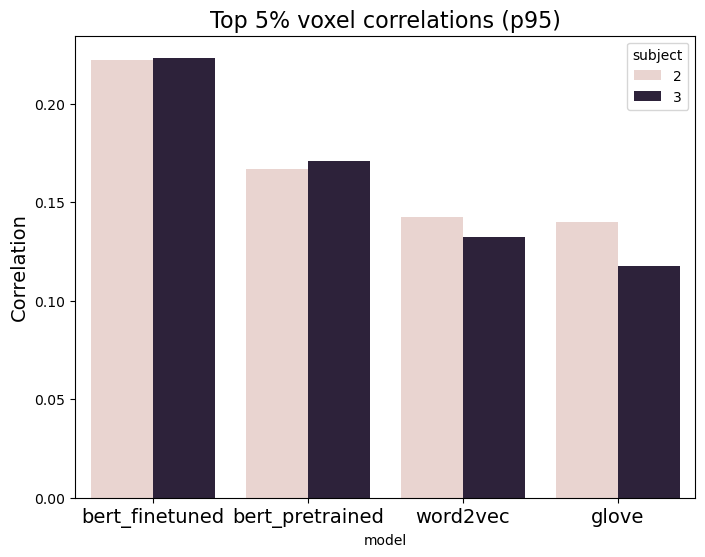

In [26]:
plot_df = summary_df.copy()

plt.figure(figsize=(8,6))
sns.barplot(data=plot_df, x="model", y="p95_cc", hue="subject")
plt.title("Top 5% voxel correlations (p95)", fontsize=16)
plt.xticks(fontsize=14) 
plt.ylabel("Correlation", fontsize=14)
plt.savefig("p95_cc_by_model_and_subject.pdf")
plt.show()

This model is good on average and good in the tail!

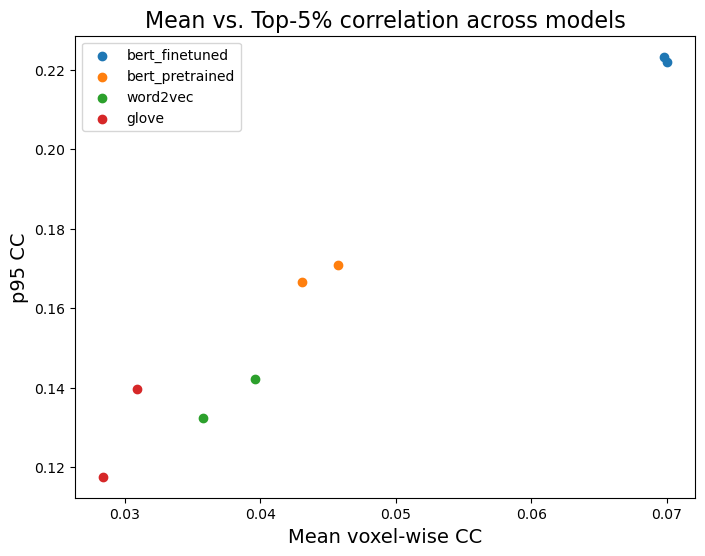

In [29]:
df = summary_df

plt.figure(figsize=(8,6))
for model in df["model"].unique():
    sub = df[df["model"] == model]
    plt.scatter(sub["mean_cc"], sub["p95_cc"], label=model)

plt.xlabel("Mean voxel-wise CC", fontsize=14)
plt.ylabel("p95 CC", fontsize=14)
plt.legend()
plt.title("Mean vs. Top-5% correlation across models", fontsize=16)
plt.savefig("../figures/mean_vs_p95_cc_by_model.pdf")
plt.show()